In [1]:
import json
ai_texts = {}
human_texts = []
for i,llm in enumerate(["allam", "openai", "jais-batched","llama-batched"]):
    for j,generation_type in enumerate(['from_title_abstracts_generation', 'from_title_and_content_abstracts_generation', 'by_polishing_abstracts_abstracts_generation']):
        with open(f"generated_arabic_datasets/{llm}/arabic_abstracts_dataset/{generation_type}_filtered.jsonl", "r") as f:
            for line in f:
                if not ai_texts.get(llm):
                    ai_texts[llm] = {}
                if not ai_texts[llm].get(generation_type):
                    ai_texts[llm][generation_type] = []
                data = json.loads(line)
                ai_texts[llm][generation_type].append(json.loads(line)['generated_abstract'])
                if i == 0 and j == 0:
                    human_texts.append(data['original_abstract'])

In [2]:
len(ai_texts['allam']), len(ai_texts['jais-batched']), len(ai_texts['llama-batched']), len(ai_texts['openai'])

(3, 3, 3, 3)

In [3]:
len(human_texts),len(ai_texts['allam']['from_title_abstracts_generation']), len(ai_texts['jais-batched']['from_title_and_content_abstracts_generation']), len(ai_texts['llama-batched']['by_polishing_abstracts_abstracts_generation'])

(2963, 2963, 2574, 2851)

In [4]:
from collections import Counter
import re

In [ ]:
import nltk
from nltk.corpus import stopwords

def remove_arabic_stopwords(text):
    # Download stop words if not already downloaded
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
        nltk.download('punkt')
    
    # Get stop words for Arabic
    stop_words = set(stopwords.words('arabic'))
    
    # Tokenize the text (split into words)
    word_tokens = text.split()
    
    # Remove stop words
    filtered_text = [word for word in word_tokens if word not in stop_words]
    
    # Join the words back together
    return ' '.join(filtered_text)

In [6]:
def preprocess_arabic_text(text: str):
        # Remove tashkeel (diacritics)
        text = re.sub(r'[\u064B-\u065F\u0670]', '', text)
        
        # Remove Arabic punctuation marks
        arabic_punctuation = '،؟؛,\:!›﴾﴿›«»۔'
        text = text.translate(str.maketrans('', '', arabic_punctuation))
        
        # Remove punctuation and special characters
        text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)
        
        # remove stop words
        text = remove_arabic_stopwords(text)

        # Convert to lowercase and split into words
        words = text.lower().split()
        
        # Remove short words (less than 2 characters)
        # words = [word for word in words if len(word.strip()) > 2]
        
        return words

In [7]:
def get_top_words(texts, n=10):
    """Get the n most frequent words from a list of texts."""
    # Combine all texts and split into words
    all_words = []
    for text in texts:
        words = preprocess_arabic_text(text)
        all_words.extend(words)
    
    # Count word frequencies
    word_counts = Counter(all_words)
    
    # Get top n words
    return word_counts.most_common(n)

In [8]:
# Analyze human texts
print("Top 10 words in human abstracts:")
human_top_words = get_top_words(human_texts)
for word, count in human_top_words:
    print(f"{word}: {count}")


Top 10 words in human abstracts:
الدراسة: 1972
خلال: 1563
البحث: 819
الجزائر: 718
وقد: 715
العربية: 639
الجزائري: 582
وذلك: 560
أهم: 551
تم: 516


In [9]:
# Analyze AI-generated texts for each model and generation type
for llm in ai_texts:
    print(f"\nAnalysis for {llm}:")
    for gen_type in ai_texts[llm]:
        print(f"\n{gen_type}:")
        ai_top_words = get_top_words(ai_texts[llm][gen_type])
        for word, count in ai_top_words:
            print(f"{word}: {count}")


Analysis for allam:

from_title_abstracts_generation:
الدراسة: 6533
تهدف: 2598
المتوقع: 2143
تحليل: 2046
خلال: 1948
الضوء: 1838
النتائج: 1791
البحث: 1764
استخدام: 1711
لتحقيق: 1447

from_title_and_content_abstracts_generation:
البحث: 5397
الدراسة: 2739
يتناول: 1763
خلال: 1058
يهدف: 1007
الجزائر: 862
دراسة: 800
يشير: 761
تهدف: 732
تحليل: 729

by_polishing_abstracts_abstracts_generation:
الدراسة: 3270
البحث: 2555
خلال: 2283
دراسة: 1169
تحليل: 1147
تهدف: 1119
الجزائر: 902
الضوء: 890
تم: 828
بشكل: 795

Analysis for openai:

from_title_abstracts_generation:
الدراسة: 6039
النتائج: 3075
تحليل: 2973
الورقة: 2306
تهدف: 2063
خلال: 1997
البحث: 1676
منهجية: 1584
تعزيز: 1511
تعتمد: 1456

from_title_and_content_abstracts_generation:
البحث: 4313
الدراسة: 3666
خلال: 1605
أهمية: 1373
الضوء: 994
تحليل: 882
يتناول: 859
تعزيز: 855
تهدف: 845
الجزائر: 820

by_polishing_abstracts_abstracts_generation:
الدراسة: 3852
البحث: 2879
خلال: 2524
تعزيز: 1427
تحليل: 1280
الضوء: 1166
أهمية: 1147
بشكل: 1124
الجزائر: 10

In [10]:
def get_shared_word_frequencies(
    ai_texts,
    human_texts,
    llms,
    generation_types,
    top_n: int = 100
):

    # Process human texts first
    human_counter = Counter()
    for text in human_texts:
        words = preprocess_arabic_text(text)
        human_counter.update(words)
    
    # Get top N words from human texts
    top_human_words = [word for word, _ in human_counter.most_common(top_n)]
    
    # Initialize result dictionary with human frequencies
    result = {
        'human': {
            word: human_counter[word]
            for word in top_human_words
        }
    }
    
    # Process AI texts, filtering to only include top human words
    for llm in llms:
        result[llm] = {}
        for gen_type in generation_types:
            counter = Counter()
            for text in ai_texts[llm][gen_type]:
                words = preprocess_arabic_text(text)
                counter.update(words)
            
            # Filter to only include top human words
            result[llm][gen_type] = {
                word: counter[word]
                for word in top_human_words
            }
    
    return result

In [11]:
get_shared_word_frequencies(
    ai_texts=ai_texts,
    human_texts=human_texts,
    llms=['allam', 'openai', 'jais-batched', 'llama-batched'],
    generation_types=['from_title_abstracts_generation', 'from_title_and_content_abstracts_generation', 'by_polishing_abstracts_abstracts_generation'],
    top_n=10
)

{'human': {'الدراسة': 1972,
  'خلال': 1563,
  'البحث': 819,
  'الجزائر': 718,
  'وقد': 715,
  'العربية': 639,
  'الجزائري': 582,
  'وذلك': 560,
  'أهم': 551,
  'تم': 516},
 'allam': {'from_title_abstracts_generation': {'الدراسة': 6533,
   'خلال': 1948,
   'البحث': 1764,
   'الجزائر': 760,
   'وقد': 2,
   'العربية': 584,
   'الجزائري': 536,
   'وذلك': 29,
   'أهم': 9,
   'تم': 387},
  'from_title_and_content_abstracts_generation': {'الدراسة': 2739,
   'خلال': 1058,
   'البحث': 5397,
   'الجزائر': 862,
   'وقد': 20,
   'العربية': 700,
   'الجزائري': 688,
   'وذلك': 53,
   'أهم': 131,
   'تم': 542},
  'by_polishing_abstracts_abstracts_generation': {'الدراسة': 3270,
   'خلال': 2283,
   'البحث': 2555,
   'الجزائر': 902,
   'وقد': 47,
   'العربية': 736,
   'الجزائري': 756,
   'وذلك': 66,
   'أهم': 158,
   'تم': 828}},
 'openai': {'from_title_abstracts_generation': {'الدراسة': 6039,
   'خلال': 1997,
   'البحث': 1676,
   'الجزائر': 738,
   'وقد': 46,
   'العربية': 559,
   'الجزائري': 551,
   '

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict
import seaborn as sns
from matplotlib.lines import Line2D

def plot_zipf_comparison(frequencies: Dict, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    
    # Function to clean generation type strings
    def clean_gen_type(gen_type: str) -> str:
        return (gen_type.replace('from_title_abstracts_generation', 'abstracts generated from title')
                       .replace('from_title_and_content_abstracts_generation', 'abstracts generated from title and content')
                       .replace('by_polishing_abstracts_abstracts_generation', 'polished abstracts'))
    
    # Function to clean LLM names
    def clean_llm_name(llm: str) -> str:
        return llm.replace('jais-batched', 'jais').replace('llama-batched', 'llama')
    
    # First, determine which LLMs and generation types are actually present
    present_llms = {clean_llm_name(llm) for llm in frequencies.keys() if llm != 'human'}
    present_gen_types = set()
    for llm in frequencies.keys():
        if llm != 'human':
            present_gen_types.update(clean_gen_type(gen_type) for gen_type in frequencies[llm].keys())
    
    # Define markers and colors only for present items
    all_markers = {
        'abstracts generated from title': 'o',
        'abstracts generated from title and content': 's',
        'polished abstracts': '^'
    }
    markers = {k: v for k, v in all_markers.items() if k in present_gen_types}
    
    # Define colors only for present LLMs
    all_colors = {
        'allam': '#1f77b4',      # blue
        'openai': '#2ca02c',     # green
        'jais': '#ff7f0e',       # orange
        'llama': '#d62728'       # red
    }
    colors = {k: v for k, v in all_colors.items() if k in present_llms}
    
    # Plot human data first with higher opacity and thicker line
    if 'human' in frequencies:
        human_freqs = sorted(frequencies['human'].values(), reverse=True)
        ranks = np.arange(1, len(human_freqs) + 1)
        human_line = plt.loglog(ranks, human_freqs, 'k-', linewidth=2, alpha=0.9)[0]
    
    # Plot each LLM and generation type with reduced alpha
    for llm in frequencies.keys():
        if llm == 'human':
            continue
            
        for gen_type in frequencies[llm].keys():
            freqs = sorted(frequencies[llm][gen_type].values(), reverse=True)
            ranks = np.arange(1, len(freqs) + 1)
            
            clean_gen = clean_gen_type(gen_type)
            clean_llm = clean_llm_name(llm)
            
            plt.loglog(ranks, freqs, 
                      marker=markers[clean_gen],
                      color=colors[clean_llm],
                      linestyle='',
                      alpha=0.3,
                      markersize=6)
    
    # Create legend elements only for present items
    llm_legend_elements = []
    if 'human' in frequencies:
        llm_legend_elements.append(Line2D([0], [0], color='black', label='Human', linewidth=2))
    
    llm_legend_elements.extend([
        Line2D([0], [0], marker='o', color=color, label=llm, 
               markerfacecolor=color, markersize=8, linestyle='')
        for llm, color in colors.items()
    ])
    
    gen_type_legend_elements = [
        Line2D([0], [0], marker=marker, color='gray', label=gen_type, 
               markerfacecolor='gray', markersize=8, linestyle='')
        for gen_type, marker in markers.items()
    ]
    
    # Add legends only if there are elements to show
    if llm_legend_elements:
        plt.gca().add_artist(plt.legend(handles=llm_legend_elements, 
                                      title='LLMs', 
                                      loc='upper right'))
    
    if gen_type_legend_elements:
        plt.gca().add_artist(plt.legend(handles=gen_type_legend_elements, 
                                      title='Generation Types',
                                      loc='lower left'))
    
    # Customize the plot
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.xlabel('Word Rank', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title("Word Frequency Distribution Comparison", fontsize=14)
    
    plt.tight_layout()
    return plt

In [13]:
word_frequencies = get_shared_word_frequencies(
    ai_texts=ai_texts,
    human_texts=human_texts,
    llms=['allam', 'openai', 'jais-batched', 'llama-batched'],
    generation_types=['from_title_abstracts_generation', 'from_title_and_content_abstracts_generation', 'by_polishing_abstracts_abstracts_generation'],
    top_n=100
)

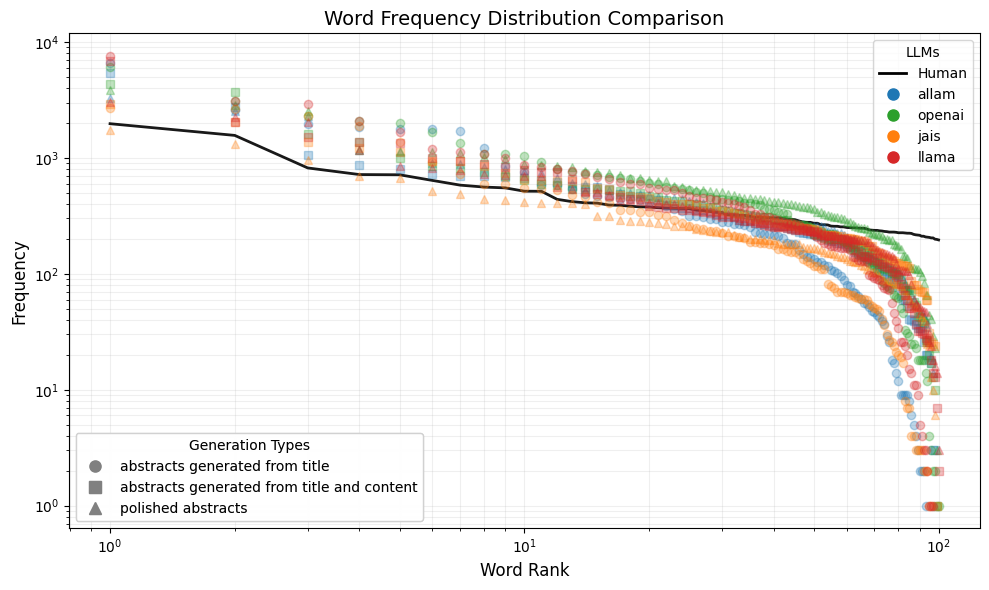

In [14]:
plot_zipf_comparison(word_frequencies)
plt.show()

In [15]:
word_frequencies = get_shared_word_frequencies(
    ai_texts=ai_texts,
    human_texts=human_texts,
    llms=['allam', 'jais-batched'],
    generation_types=['from_title_and_content_abstracts_generation'],
    top_n=100
)

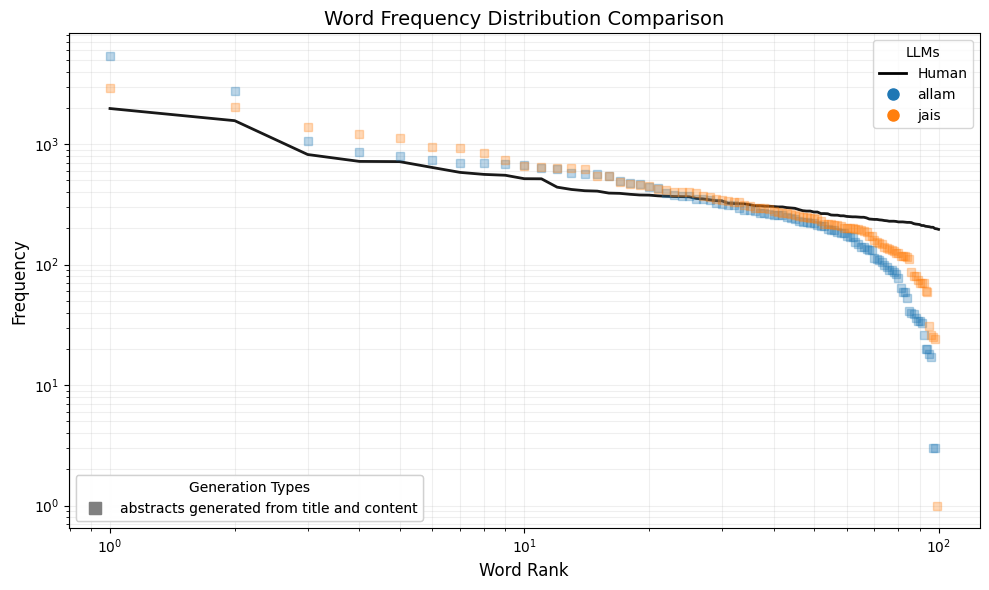

In [16]:
plot_zipf_comparison(word_frequencies)
plt.show()

In [17]:
word_frequencies = get_shared_word_frequencies(
    ai_texts=ai_texts,
    human_texts=human_texts,
    llms=['allam', 'openai'],
    generation_types=['by_polishing_abstracts_abstracts_generation'],
    top_n=100
)

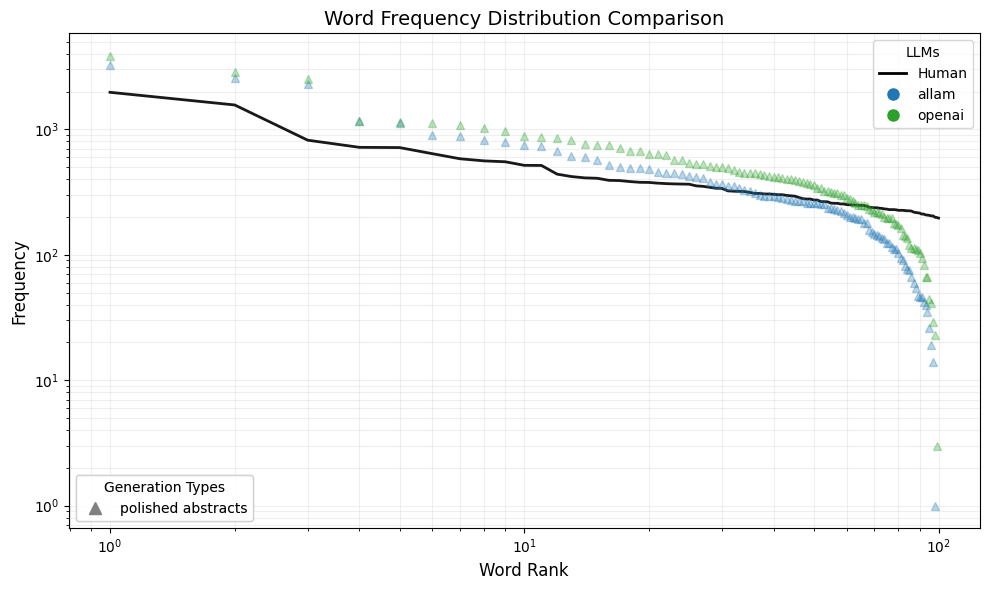

In [18]:
plot_zipf_comparison(word_frequencies)
plt.show()